***

<h1><center> Sales Forecasting ML Model</center></h1>
<h2><center>Created by: Ginta Grinfelde</center></h2> 

***

# Importing Libraries

In [1]:
import pandas as pd
import pandas.io.sql as psql
from tslearn.utils import to_time_series
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor

## Objective

The data set for this notebook was provided by a retail store Rossmann and was found on the Kaggle website (https://www.kaggle.com/c/rossmann-store-sales). Rossman operates over 4,000 drug stores in 7 European countries.
The objective of this project is to create a Regression ML model that can accurately predict daily sales for multiple stores for three months. I chose to use the r2 score to measure my models' performance  and show how well my features explain the variations in sales. I will also look at the Mean Squared Error to see if it improves with different models

## Data
The dataset was taken from the Kaggle website ('Rossmann Store Sales') and consists of three csv files:
- Rossman daily Sales for each store:
    - Training Set
    - Test set (without labels) for the Kaggle competition
- Store data with information about the stores, their competition and promotions

To test my model in the Kaggle competition, I will also be using a Test data set provided by the website.

#### Column Explanations
Most columns are self explanatory, the rest are described below.
- Id - an Id that represents a (Store, Date) duple within the test set 
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
# Loading the store and training Data
df_r = pd.read_csv('/rossman.csv')
df_s = pd.read_csv('/store.csv')

In [3]:
# Loading the test Dataset
df_test = pd.read_csv('/test.csv')


In [4]:
# Store Dataset
df_s.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
# Rossman Daily Sales Dataset
df_r.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


To use information from both tables, I decided to join the Sales dataset with the Store Data set using left join

In [5]:
# Joining the training DataFrame with the store data using the Store number
df = df_r.merge(df_s, on='Store', how='left')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
# Joining the test Data Frame with the store data using the Store number
df_test = df_test.merge(df_s, on='Store', how='left')
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [8]:
# Creating a list with both data frames for easier transformation
df_full = [df, df_test]

## Exploratory Data Analysis

It can be seen that the DataFrame consists of 18 columns and 1017209 rows with most columns being integers and floats. 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

##### Null Values

Null values can only be found in the Competition and Promotion rows.

In [10]:
print(df.isna().sum())

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


#### Categorical features
There are only 4 categorical features with 3 to 5 unique values. It can also be seen that the Date column is not in the Date format.

In [11]:
df.describe(include='object')

,Date,StateHoliday,StoreType,Assortment,PromoInterval
count,1017209,1017209,1017209,1017209,509178
unique,942,5,4,3,3
top,2015-07-31,0,a,a,"Jan,Apr,Jul,Oct"
freq,1115,855087,551627,537445,293122


In [12]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


Time frame for the training data set is from 2013-01 until 2015-07

In [13]:
print('Data start Date:', df['Date'].min())
print('Data end Date:', df['Date'].max())

Data start Date: 2013-01-01
Data end Date: 2015-07-31


In [14]:
# Transforming the Date feature to the correct format for all DataFrames
for x in df_full:
    x['Date'] = pd.to_datetime(x['Date'])

A first glance on the average daily sales shows seasonality with some spikes during the year

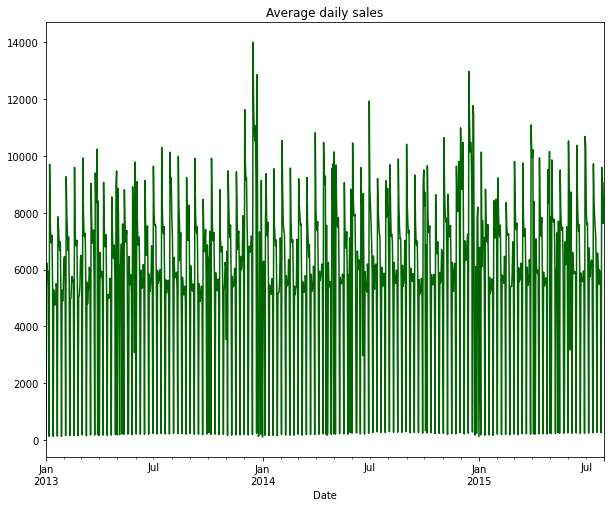

In [15]:
df.groupby('Date')['Sales'].mean().plot(figsize=(10,8), title='Average daily sales', color='darkgreen');

### Sales 

From the below graphs it can be seen that indeed December has the highest revenue which can be explained with the holiday season. Even though Rossmann is a drug store, it also sells gifts and seasonal products. Perhaps this is the reason why the month of May also has slightly higher average sales.

The sales per year graph does not show any significant differences between the three years.

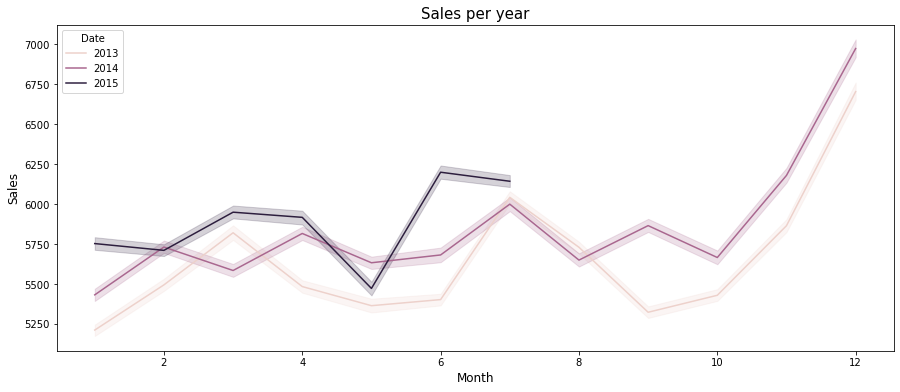

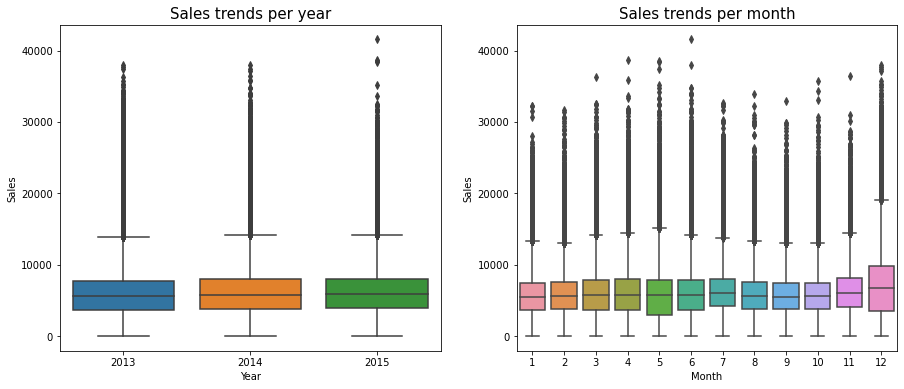

In [16]:
variable = 'Sales'
fig, ax = plt.subplots(figsize=(15, 6));

sns.lineplot(df['Date'].dt.month, df[variable], hue=df['Date'].dt.year);
ax.set_title('Average Daily Sales per year', fontsize = 15, loc='center');
ax.set_xlabel('Month', fontsize = 12);
ax.set_ylabel('Sales', fontsize = 12);


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6));

sns.boxplot(df['Date'].dt.year, df[variable], ax=ax[0]);
ax[0].set_title('Sales trends per year', fontsize = 15, loc='center');
ax[0].set_xlabel('Year', fontsize = 10);
ax[0].set_ylabel('Sales', fontsize = 10);

sns.boxplot(df['Date'].dt.month, df[variable], ax=ax[1]);
ax[1].set_title('Sales trends per month', fontsize = 15, loc='center');
ax[1].set_xlabel('Month', fontsize = 10);
ax[1].set_ylabel('Sales', fontsize = 10);

Checking the total sales per year does show that year 2015 has lower sales, but after checking the time frame, I realised that I only have 7 months of data for this year.

Total Sales:
 Date
2013    2302876084
2014    2180804896
2015    1389499643
Name: Sales, dtype: int64


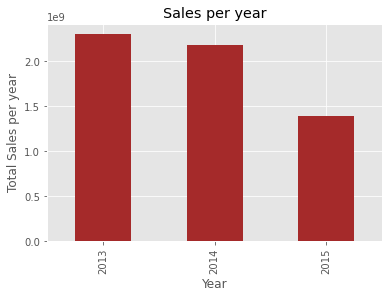

In [17]:
plt.style.use('ggplot')
year = df['Date'].dt.year
print('Total Sales:\n', df.groupby(year)['Sales'].sum())
df.groupby(year)['Sales'].sum().plot(kind='bar', color='brown', title='Sales per year');
plt.xlabel('Year');
plt.ylabel('Total Sales per year');

#### Sales Correlation with other variables
Features that are closesly correlated to Sales are DayOfWeek, Customers, Promo and if the store is open.

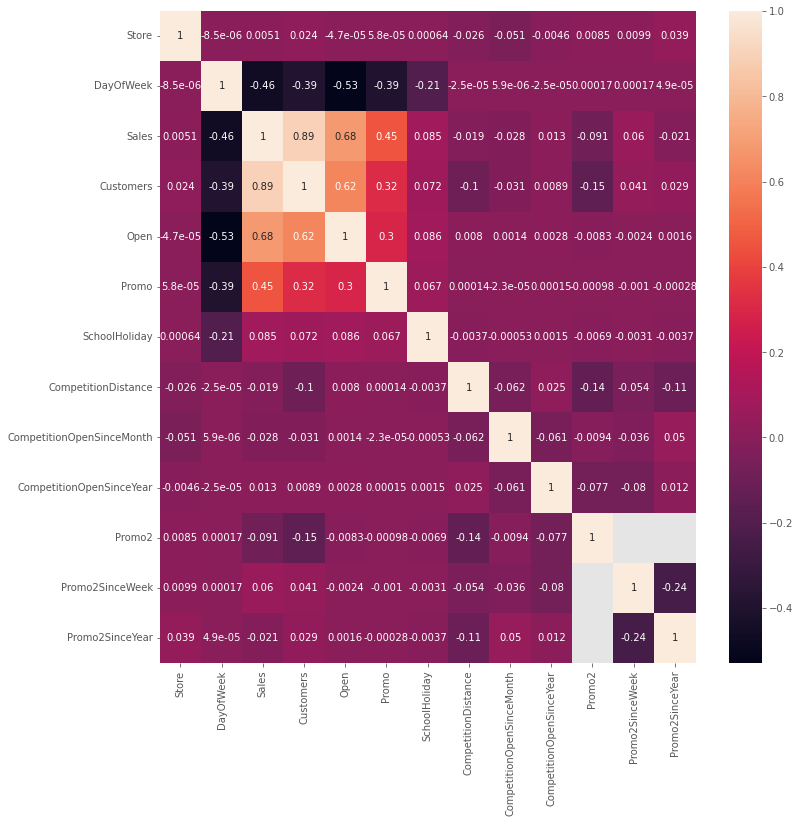

In [18]:
plt.figure(figsize = (12,12))
sns.heatmap(df.corr(), annot=True);


### Store
The Store feature only shows the store number, there are 1115 different stores in the DataSet.

In [19]:
print('Number of stores in the data set:', df['Store'].nunique())

Number of stores in the data set: 1115


### Day of week
By looking at the Day of the week data, it can be seen that Sunday has very low sales on average.

Average Sales per Day of the Week: DayOfWeek
1    7809.044510
2    7005.244467
3    6555.884138
4    6247.575913
5    6723.274305
6    5847.562599
7     204.183189
Name: Sales, dtype: float64


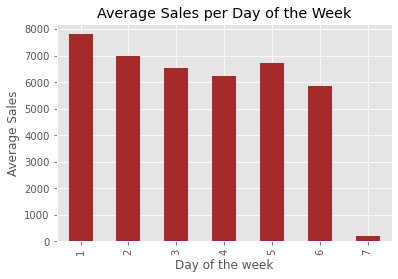

In [20]:
print('Average Sales per Day of the Week:', df.groupby('DayOfWeek')['Sales'].mean())

plt.style.use('ggplot')
df.groupby('DayOfWeek')['Sales'].mean().plot(kind='bar', color='brown', title='Average Sales per Day of the Week');
plt.xlabel('Day of the week');
plt.ylabel('Average Sales');

The Rossmann stores are located in countries where most stores are closed on Sundays. Therefore, I divided the data into two categories - open on Sundays and closed on Sundays - to check what are the average day of the week sales for both categories.

Surprisingly, the highest average sales are on Mondays for both groups and weekends generally have lower sales. The explanation could be that stores are open for fewer hours on weekends.

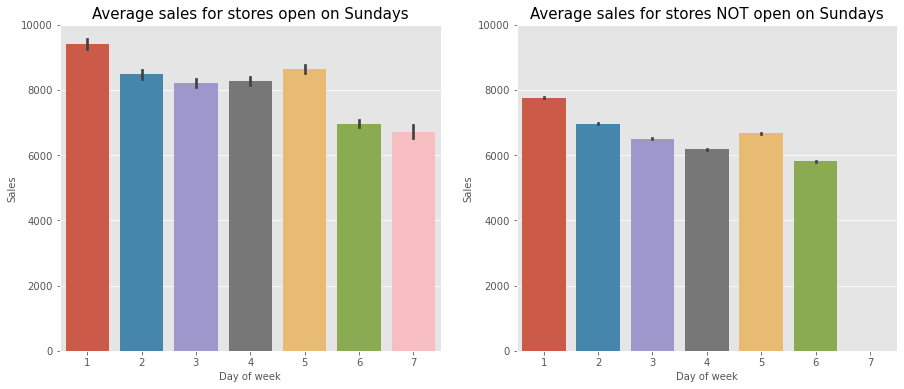

In [21]:
sunday_sales = df[(df['DayOfWeek'] == 7) & (df['Sales'] > 0)]
store_list = sunday_sales['Store'].to_list()
df_open_sundays = df[df['Store'].isin(store_list)]
df_not_open_sundays = df[~df['Store'].isin(store_list)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6));

sns.barplot(df_open_sundays['DayOfWeek'], df['Sales'], ax=ax[0]);
ax[0].set_title('Average sales for stores open on Sundays', fontsize = 15, loc='center');
ax[0].set_xlabel('Day of week', fontsize = 10);
ax[0].set_ylabel('Sales', fontsize = 10);
ax[0].set(ylim=(0, 10000));

sns.barplot(df_not_open_sundays['DayOfWeek'], df['Sales'], ax=ax[1]);
ax[1].set_title('Average sales for stores NOT open on Sundays', fontsize = 15, loc='center');
ax[1].set_xlabel('Day of week', fontsize = 10);
ax[1].set_ylabel('Sales', fontsize = 10);
ax[1].set(ylim=(0, 10000));

### Open
This feature just shows if the store is open, and a quick check confirms that there are no sales during the days when the store is closed (indicating clean data). In the data set, in 83% of the instances, the stores were open.

In [23]:
print('Value counts:\n', df['Open'].value_counts(normalize=True))

#checking if the data is correct and the Sales in closed days are zero
print('Average sales:',df.groupby('Open')['Sales'].mean())

Value counts:
 1    0.830107
0    0.169893
Name: Open, dtype: float64
Average sales: Open
0       0.000000
1    6955.514291
Name: Sales, dtype: float64


### Promos


- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

From the below graphs, it can be seen that Promo has a higher impact than Promo2 variable and Promo2 even has better average scores in the stores that are not participating in the long term promotions.

Value counts Promo:
 0    0.618485
1    0.381515
Name: Promo, dtype: float64
Value counts Promo2:
 1    0.500564
0    0.499436
Name: Promo2, dtype: float64


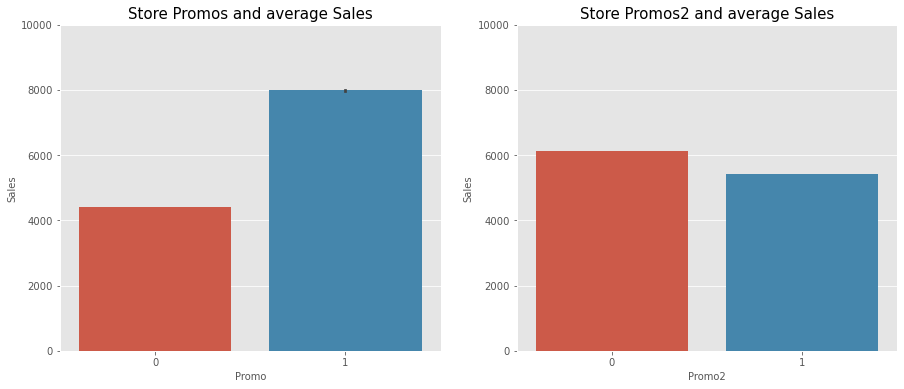

In [24]:
print('Value counts Promo:\n', df['Promo'].value_counts(normalize=True))
print('Value counts Promo2:\n', df['Promo2'].value_counts(normalize=True))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6));

sns.barplot(df['Promo'],df['Sales'], ax=ax[0]);
ax[0].set_title('Store Promos and average Sales', fontsize = 15, loc='center');
ax[0].set_xlabel('Promo', fontsize = 10);
ax[0].set_ylabel('Sales', fontsize = 10);
ax[0].set(ylim=(0, 10000));

sns.barplot(df['Promo2'],df['Sales'], ax=ax[1]);
ax[1].set_title('Store Promos2 and average Sales', fontsize = 15, loc='center');
ax[1].set_xlabel('Promo2', fontsize = 10);
ax[1].set_ylabel('Sales', fontsize = 10);
ax[1].set(ylim=(0, 10000));

The three features - Promo2SinceWeek, Promo2SinceYear and PromoInterval, have almost 50% missing values. At a closer look, all the missing values are from the stores where Promo2 was not active which explains it and could be later imputed with a 0.

In [25]:
print('Promo2 Since Week Missing values:', (df['Promo2SinceWeek'].isna().sum()) / (df.shape[0]))
print('Promo2 Since Year Missing values:', (df['Promo2SinceYear'].isna().sum())  / (df.shape[0]))
print('Promo Interval Missing values:', (df['PromoInterval'].isna().sum()) / (df.shape[0]))

Promo2 Since Week Missing values: 0.49943620239301856
Promo2 Since Year Missing values: 0.49943620239301856
Promo Interval Missing values: 0.49943620239301856


Further exploration of the three features do not show significant difference in sales for each category.

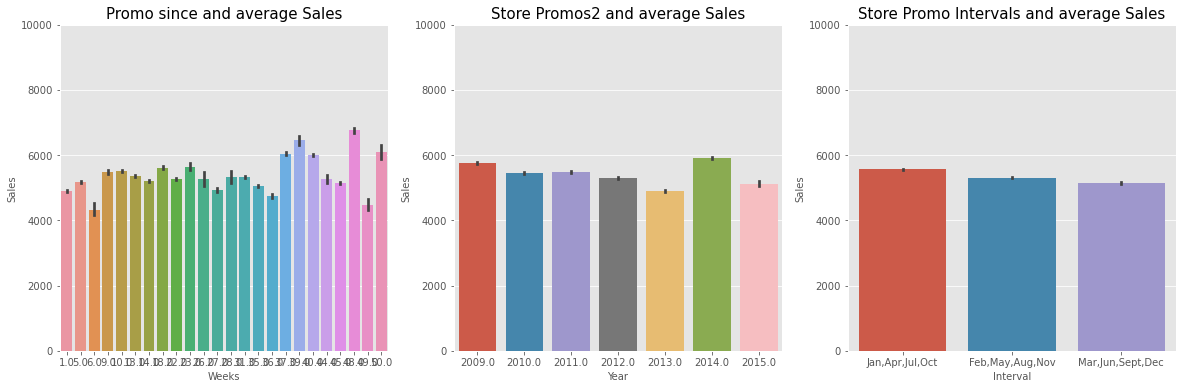

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6));

sns.barplot(df['Promo2SinceWeek'],df['Sales'], ax=ax[0]);
ax[0].set_title('Promo since and average Sales', fontsize = 15, loc='center');
ax[0].set_xlabel('Weeks', fontsize = 10);
ax[0].set_ylabel('Sales', fontsize = 10);
ax[0].set(ylim=(0, 10000));

sns.barplot(df['Promo2SinceYear'],df['Sales'], ax=ax[1]);
ax[1].set_title('Store Promos2 and average Sales', fontsize = 15, loc='center');
ax[1].set_xlabel('Year', fontsize = 10);
ax[1].set_ylabel('Sales', fontsize = 10);
ax[1].set(ylim=(0, 10000));

sns.barplot(df['PromoInterval'],df['Sales'], ax=ax[2]);
ax[2].set_title('Store Promo Intervals and average Sales', fontsize = 15, loc='center');
ax[2].set_xlabel('Interval', fontsize = 10);
ax[2].set_ylabel('Sales', fontsize = 10);
ax[2].set(ylim=(0, 10000));

### State Holiday
State Holidays feature shows that there are two 0 as categories, one a string and one an intege, I replaced the integer with the string version.

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64


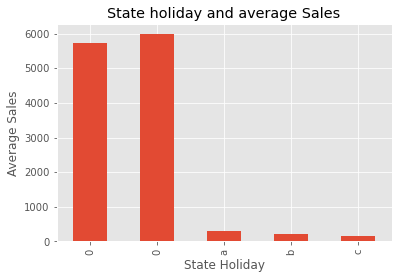

In [27]:
print(df['StateHoliday'].value_counts())

plt.style.use('ggplot')
df.groupby('StateHoliday')['Sales'].mean().plot(kind='bar', title='State holiday and average Sales');

plt.xlabel('State Holiday');
plt.ylabel('Average Sales');

In [28]:
# Replace the integer with a string for both Data Frames
for x in df_full:
    x['StateHoliday'] = x['StateHoliday'].replace(0, str(0))

Checking the average sales for only state holidays, it can be seen  that holidays b and c have the highest average sales.

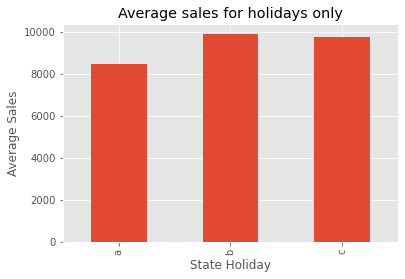

In [29]:
no_null = df[(df['StateHoliday'] != '0') & (df['Sales'] > 0)]

plt.style.use('ggplot')
no_null.groupby('StateHoliday')['Sales'].mean().plot(kind='bar', title='Average sales for holidays only');

plt.xlabel('State Holiday');
plt.ylabel('Average Sales');

### School Holiday

School holidays on average have higher sales.

0    835488
1    181721
Name: SchoolHoliday, dtype: int64


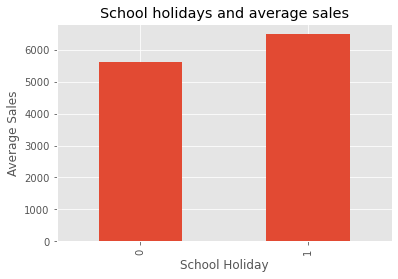

In [137]:
print(df['SchoolHoliday'].value_counts())

plt.style.use('ggplot')
df.groupby('SchoolHoliday')['Sales'].mean().plot(kind='bar', title='School holidays and average sales');

plt.xlabel('School Holiday');
plt.ylabel('Average Sales');

### Store type and Assortment type

- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- StoreType - differentiates between 4 different store models: a, b, c, d

Store type b has almost twice the average sales than other types. Perhaps these stores are larger than the rest of the categories or are in countries where prices are genreally higher.

Furthermore, Assortment b has higher average sales. 

Store Type value counts:
 a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64
Store Assortment value counts:
 a    537445
c    471470
b      8294
Name: Assortment, dtype: int64


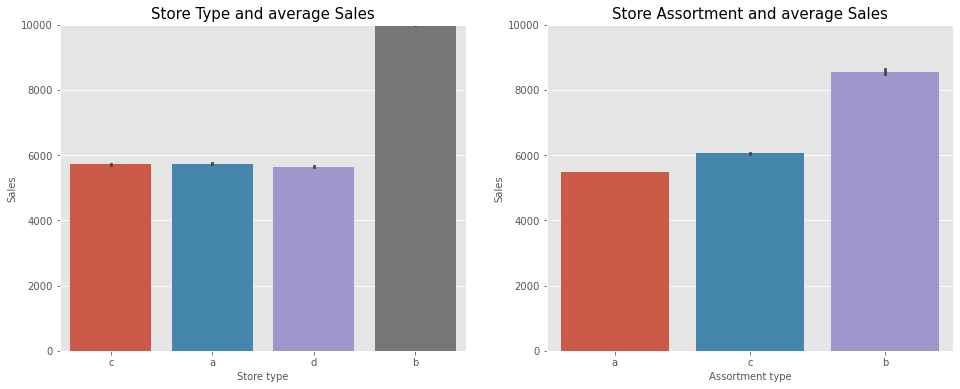

In [31]:
print('Store Type value counts:\n', df['StoreType'].value_counts())
print('Store Assortment value counts:\n', df['Assortment'].value_counts())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6));

sns.barplot(df['StoreType'],df['Sales'], ax=ax[0]);
ax[0].set_title('Store Type and average Sales', fontsize = 15, loc='center');
ax[0].set_xlabel('Store type', fontsize = 10);
ax[0].set_ylabel('Sales', fontsize = 10);
ax[0].set(ylim=(0, 10000));

sns.barplot(df['Assortment'],df['Sales'], ax=ax[1]);
ax[1].set_title('Store Assortment and average Sales', fontsize = 15, loc='center');
ax[1].set_xlabel('Assortment type', fontsize = 10);
ax[1].set_ylabel('Sales', fontsize = 10);
ax[1].set(ylim=(0, 10000));

### Competition

Competition distance and times when they opened do not seem to have high correlation with the Sales variable

Correlation between Competition distance and Sales: -0.019229200503110448
Correlation between Competition open by month and Sales: -0.028256780998140506
Missing values for Competition Distance: 2642
Missing values for CompetitionOpenSinceMonth: 323348


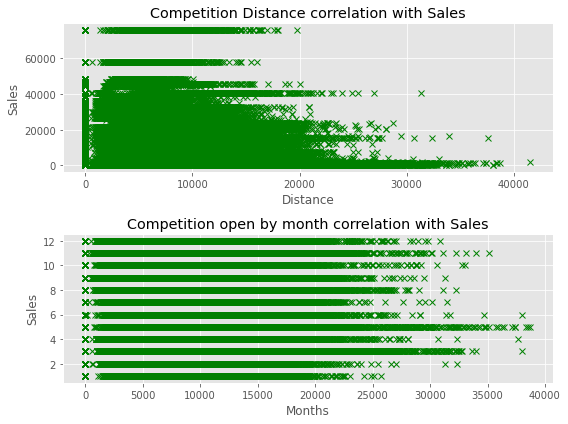

In [32]:
fig,axs = plt.subplots(2, figsize=(8,6))

axs[0].plot(df['Sales'], df['CompetitionDistance'], 'x', color='g');
axs[0].set_title('Competition Distance correlation with Sales');
axs[0].set_xlabel('Distance');
axs[0].set_ylabel('Sales');

axs[1].plot(df['Sales'], df['CompetitionOpenSinceMonth'], 'x', color='g');
axs[1].set_title('Competition open by month correlation with Sales');
axs[1].set_xlabel('Months');
axs[1].set_ylabel('Sales');


fig.tight_layout();

print('Correlation between Competition distance and Sales:', df['Sales'].corr(df['CompetitionDistance']))
print('Correlation between Competition open by month and Sales:', df['Sales'].corr(df['CompetitionOpenSinceMonth']))
print('Missing values for Competition Distance:', df['CompetitionDistance'].isna().sum())
print('Missing values for CompetitionOpenSinceMonth:', df['CompetitionOpenSinceMonth'].isna().sum())

In [33]:
# The CompetitionOpenSinceYear has a lot of missing values
print(df['CompetitionOpenSinceYear'].value_counts())
print('Missing values for Competition year:', df['CompetitionOpenSinceYear'].isna().sum())


2013.0    75426
2012.0    74299
2014.0    63732
2005.0    56564
2010.0    51258
2009.0    49396
2011.0    49396
2008.0    48476
2007.0    43744
2006.0    42802
2015.0    35060
2002.0    24882
2004.0    19804
2003.0    16794
2001.0    14704
2000.0     9236
1999.0     7352
1990.0     4710
1994.0     1884
1995.0     1700
1961.0      942
1998.0      942
1900.0      758
Name: CompetitionOpenSinceYear, dtype: int64
Missing values for Competition year: 323348


## Splitting the data set

Before feature engineering, I am splitting my training set in training and validation sets. I decided to take 3 months worth of Data to be the validation set. The validation set will only be used once at the end of the notebook.

In [34]:
#Setting the date as the index and sorting the data 
df['Date_i'] = df['Date']
df.set_index('Date_i', inplace=True)
df.sort_index(inplace=True)

In [35]:
# Doing the same for the kaggle test set
df_test['Date_i'] = df_test['Date']
df_test.set_index('Date_i', inplace=True)
df_test.sort_index(inplace=True)

In [36]:
# SValidation set will be the 3 last months of the data set
df_train = df[df.index < '2015-05-01']
df_valid = df[df.index >= '2015-05-01']

In [37]:
#Training set
print(df_train['Date'].min())
print(df_train['Date'].max())

2013-01-01 00:00:00
2015-04-30 00:00:00


In [38]:
#Validation set
print(df_valid['Date'].min())
print(df_valid['Date'].max())

2015-05-01 00:00:00
2015-07-31 00:00:00


In [39]:
#creating a new list with all three data sets for easier feature engineering
df_full = [df_train, df_valid, df_test]

## Feature Engineering

##### Store open on Sundays
EDA showed that the stores that are open on Sundays had higher average sales, thus,I will create a new feature that shows if the store is open on Sundays. 

In [40]:
for x in df_full:
    x['OpenSundays'] = x['Store'].isin(store_list).astype(int)

In [41]:
df_train['OpenSundays'].corr(df_train['Sales'])

0.10325182253087031

##### Month
Different months also had different average sales so adding a new Month feature.

In [42]:
for x in df_full:
    x['Month'] = x['Date'].dt.month

In [43]:
df_train['Month'].corr(df_train['Sales'])

0.04957916463609221

##### Days until Christmas
Christmas time had the highest time of the year so a new feature showing the absolute value of days to the closest or previous Christmas

In [44]:
df_train['Christmas'] = ['2013-12-25' if d ==2013 else ('2014-12-25' if d == 2014 else '2015-12-25') for d in df_train['Date'].dt.year]
df_valid['Christmas'] = ['2013-12-25' if d ==2013 else ('2014-12-25' if d == 2014 else '2015-12-25') for d in df_valid['Date'].dt.year]
df_test['Christmas'] = ['2013-12-25' if d ==2013 else ('2014-12-25' if d == 2014 else '2015-12-25') for d in df_test['Date'].dt.year]
df_train['Christmas'] = pd.to_datetime(df_train['Christmas'])
df_valid['Christmas'] = pd.to_datetime(df_valid['Christmas'])
df_test['Christmas'] = pd.to_datetime(df_test['Christmas'])

In [45]:
for x in df_full:
    x['Days_to_Christmas'] = x['Date'] - x['Christmas']
    x['Days_to_Christmas'] = x['Days_to_Christmas'].astype(str).str.replace('days', '').astype(int).abs()

In [46]:
df_train['Days_to_Christmas'].corr(df_train['Sales'])

-0.04863689645910513

I made the 'Days to Christmas' feature an absolute number and it can be seen that sales are much higher with the lower values.

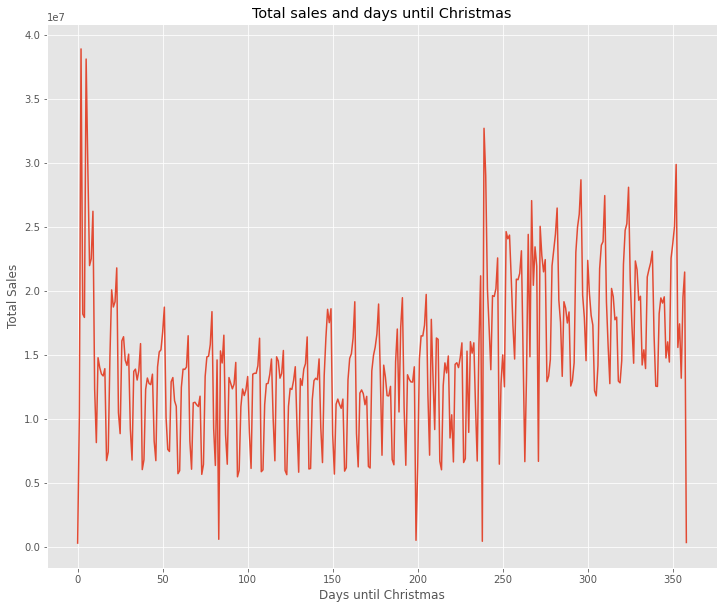

In [47]:
df_train.groupby('Days_to_Christmas')['Sales']\
                        .sum().plot(figsize=(12,10), title='Total sales and days until Christmas');
plt.xlabel('Days until Christmas');
plt.ylabel('Total Sales');

##### Weekend and Weekday

Weekends had lower sales so I'm adding a variable to show which ones are weekends/weekedays

In [48]:
for x in df_full:
    x['Weekend_weekday'] = x['DayOfWeek'].apply(lambda x: 'Weekday' if x<6 else 'Weekend')


##### Store ranking
Creating a list with rankings for each store based on average sales and adding a new feature 'Rank'. It shows a high correlation to Sales so could be a good feature for my model.

In [49]:
# Creating a dictionary with store numbers and ranking
store_ranking = df.groupby('Store')['Sales'].mean().sort_values(ascending=False).rank(ascending=False).to_dict()

In [50]:
#Creating a new feature Rank for each data frame
for x in df_full:
    x['Rank'] = [int(store_ranking[r]) for r in x['Store']]

In [51]:
# Correlation with sales
df_train['Rank'].corr(df_train['Sales'])

-0.47040876325826614

##### Average historical sales per store per date
Creating a feature that shows the historical average sales per store per month.

In [52]:
# Creating a month-day feature for easier 
for x in df_full:
    x['Mon_Day'] = x['Date'].dt.strftime('%m-%d')

In [53]:
# Creating a dictionary for average historical sales per store per date
avg_dict = df.groupby(['Store', (df['Date'].dt.strftime('%m-%d'))])['Sales'].mean().to_dict()

In [54]:
# Adding the average sales in all data frames
for x in df_full:
    x['avg'] = [round(avg_dict[x['Store'].iloc[i], x['Mon_Day'].iloc[i]],2) for i, r in enumerate(x['Store'])]

In [55]:
df_train['avg'].corr(df_train['Sales'])

0.7605492952623687

## Data Preprocessing and  Base Models

Creating the X and y variables for training and validation sets

In [56]:
X_train = df_train.drop(columns='Sales')
y_train = df_train['Sales']

X_valid = df_valid.drop(columns='Sales')
y_valid = df_valid['Sales']

Dividing features into categorical and numerical categories. I decided to drop features about promotion2 because they had a lot of missing values and they did not seem to be good predictors based on the EDA stage. I'm also dropping helper columns.

Furthermore, the Customers column is not in the test data so must be dropped from the training model

In [57]:
drop = ['Promo2SinceWeek', 'Promo2SinceYear', 'Christmas', 'Date', 'Customers', 'Mon_Day']

ohe_features = ['StateHoliday', 'StoreType', 'Weekend_weekday', 'Assortment', 'PromoInterval', ]

numerical_features = ['Store', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'DayOfWeek', \
                      'SchoolHoliday' , 'Open', 'Promo', 'CompetitionDistance',\
                   'Promo2', 'OpenSundays', 'Month', 'Days_to_Christmas', 'Rank', 'avg'] 


Creating a pipeline for numerical features. The missing values are imputed with mean values and all are scaled.

In [58]:
numeric_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                                  ('scaler', StandardScaler())])

Creating a pipeline for categorical features. Because the only missing values are in the promotion column, I'm creating a new category showing that the store does not have a promotion. Furthermore, using One Hot Encoder for encoding values.

In [59]:
categoric_pipeline = Pipeline(steps=[('cat_imp', SimpleImputer(strategy='constant', fill_value='0')),
                                     ('ohe', OneHotEncoder())])

Creating Column Transformer:
- Dropping unneccessary features
- Imputing missing values
- Scaling the numerical features
- Using the One Hot Encoder to encode categorical features

In [60]:
transformers  = [('drop_columns', 'drop', drop),
                ('num_pipeline', numeric_pipeline, numerical_features),
                ('cat', categoric_pipeline, ohe_features)]
                    
preprocessing = ColumnTransformer(transformers=transformers, remainder='passthrough', n_jobs=-1)

Creating a function to try out multiple Regression Models

In [61]:
def model_scores(model, X, y):
    
    steps = [('preprocessor', preprocessing),
           ('model', model)]
    
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X, y)
    
    # getting the mean from the r2 scores
    r2_mean_score = (cross_val_score(pipeline, X, y, cv=5, scoring='r2', n_jobs=-1)).mean()
    print('R2 mean score:', r2_mean_score)
    
     # getting the mean from the MSE scores
    MSE_mean_score = (cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)).mean()
    print('MSE mean score:', MSE_mean_score)

##### Linear Regression
Linear regression shows an R2 score  of 82 and the MSE is quite large.

In [62]:
model_scores(LinearRegression(), X_train, y_train)

R2 mean score: 0.8262403760988342
MSE mean score: -2551219.1919467086


##### XGB Regressor

XGB further improves the R2 score and further decreases the MSE score. 

In [64]:
model_scores(XGBRegressor(), X_train, y_train)

R2 mean score: 0.8971868583443919
MSE mean score: -1520978.1296372558


### XGBoost Model Interpretation

Fitting the data to the XGB model to look at feature importances using eli5 library

In [65]:
steps_xgb = [('preprocessor', preprocessing),
             ('xgb', XGBRegressor())]
    
xgb_pipeline = Pipeline(steps=steps_xgb)

xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('drop_columns', 'drop',
                                                  ['Promo2SinceWeek',
                                                   'Promo2SinceYear',
                                                   'Christmas', 'Date',
                                                   'Customers', 'Mon_Day']),
                                                 ('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Store',
                                                   'CompetitionOpenSinceMonth',


In [66]:
# Getting column names from the pipeline and the numerical features list
ohe_column_names = list(xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']\
                    .get_feature_names(input_features=ohe_features))
numeric_features_list = list(numerical_features)

In [67]:
numeric_features_list.extend(ohe_column_names)

Based on the below model interpretation, Open and average sales features have the highest importance in determining the daily sales. Furthermore, the weekend variable I created is not used by my model at all so it might be good to remove it from the model.

In [68]:
eli5.explain_weights(xgb_pipeline.named_steps['xgb'], top=50, feature_names=numeric_features_list)

Weight,Feature
0.6967,Open
0.1382,avg
0.0586,Promo
0.0374,Rank
0.0111,DayOfWeek
0.0079,StoreType_a
0.0069,OpenSundays
0.0063,Assortment_b
0.0048,Days_to_Christmas
0.0044,SchoolHoliday


## Feature correlation
After checking the correlation between the features, I found that the below are highly correlated:
- Days until Christmas and Month
- Rank and Avg sales

To have a better performing model, I will drop the features Month and Rank to see if it will improve the score.

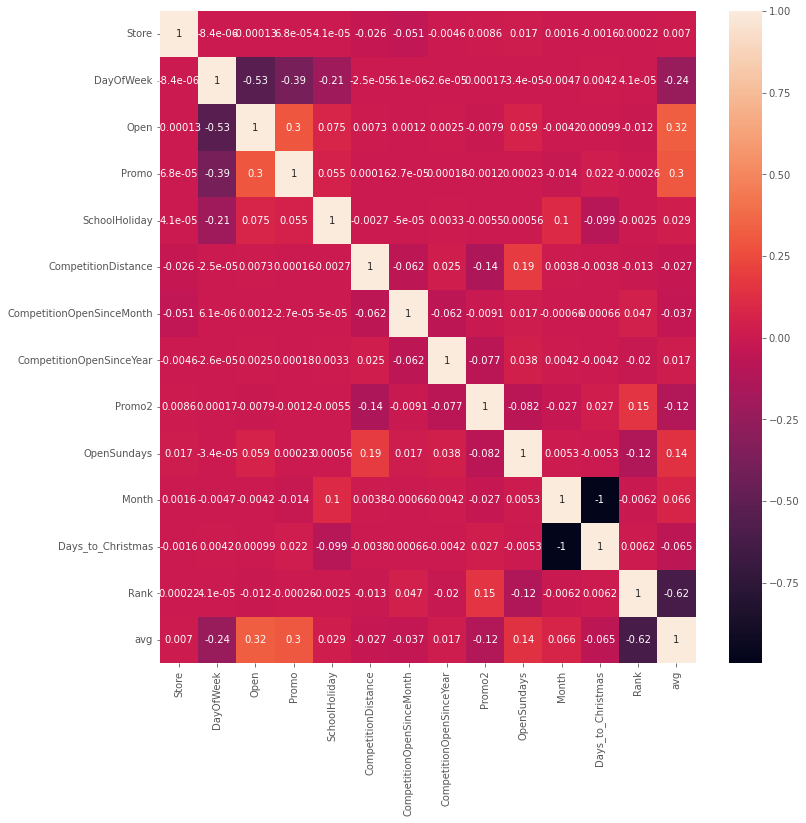

In [78]:
plt.figure(figsize = (12,12))
sns.heatmap(X_train.drop(columns=drop).corr(), annot=True);


### Improving the model

By dropping highly correlated features  - Month, avg and Weekend_weekday - the r2 score has improved.

In [89]:
drop = ['Promo2SinceWeek', 'Promo2SinceYear', 'Christmas', 'Date', 'Customers', 'Mon_Day',\
        'Month', 'avg','Weekend_weekday']

ohe_features = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

numerical_features = ['Store', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'DayOfWeek', \
                      'SchoolHoliday' , 'Open', 'Promo', 'CompetitionDistance',\
                   'Promo2', 'OpenSundays', 'Days_to_Christmas', 'Rank'] 

numeric_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                                  ('scaler', StandardScaler())])

categoric_pipeline = Pipeline(steps=[('cat_imp', SimpleImputer(strategy='constant', fill_value='0')),
                                     ('ohe', OneHotEncoder())])

transformers  = [('drop_columns', 'drop', drop),
                ('num_pipeline', numeric_pipeline, numerical_features),
                ('cat', categoric_pipeline, ohe_features)]
                    
preprocessing = ColumnTransformer(transformers=transformers, remainder='passthrough', n_jobs=-1)


steps_xgb = [('preprocessor', preprocessing),
           ('xgb', XGBRegressor())]

pipeline = Pipeline(steps=steps_xgb)
pipeline.fit(X_train, y_train)

# getting the mean from the r2 scores
r2_mean_score = (cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)).mean()
print('R2 mean score:', r2_mean_score)

R2 mean score: 0.9205635887935341


### Hyperparameter tuning
Trying out multiple hyperparameters only slightly improved the score. In the interest of time, I could not increase the amount of hyperparameters.

In [90]:
xgb_steps = [('preprocessor', preprocessing),
             ('xgb', XGBRegressor())]
    
xgb_pipeline = Pipeline(steps=xgb_steps)


xgb_parameters = {
    'xgb__max_depth': [10, 13],
    'xgb__n_estimators': [50,100],
    'xgb__learning_rate': [0.1, 0.2, 0.3]}


gscv = GridSearchCV(xgb_pipeline, xgb_parameters, cv=3, scoring='r2', n_jobs=-1, error_score='raise')

gscv.fit(X_train, y_train)

best_model = gscv.best_estimator_
print('R2 score from the gridsearch model:', gscv.best_score_)
print('Best max_depth:', best_model.get_params()['xgb__max_depth'])
print('N_estimators:', best_model.get_params()['xgb__n_estimators'])
print('Best learning rate:', best_model.get_params()['xgb__learning_rate'])

R2 score from the gridsearch model: 0.9212618630579699
Best max_depth: 13
N_estimators: 50
Best learning rate: 0.1


### Stacking
I tried 2 stacking options and both increased the r2 score. I settled on the last one to be my final model.

In [100]:
estimators= [('xgb', XGBRegressor(max_depth=13, n_estimators=50, learning_rate=0.1)),
            ('rf', RandomForestRegressor(max_depth=15)),
            ('xgb2', XGBRegressor(max_depth=10, n_estimators=50, learning_rate=0.2)),
            ( 'rf2', RandomForestRegressor(max_depth=20))]

stack = StackingRegressor(estimators=estimators,
        final_estimator=LinearRegression(), cv=5)

steps = [('preprocessor', preprocessing),
           ('stack', stack)]
    
stacking = Pipeline(steps=steps)

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_train, y_train, random_state=42)

stacking.fit(X_train_s, y_train_s).score(X_val_s, y_val_s)

0.9613696281858456

In [104]:
estimators= [('xgb', XGBRegressor(max_depth=13, n_estimators=50, learning_rate=0.1)),
            ('rf', RandomForestRegressor(max_depth=15)),
            ('xgb2', XGBRegressor(max_depth=10, n_estimators=50, learning_rate=0.2)),
            ( 'rf2', RandomForestRegressor(max_depth=20)),
            ('xgb3', XGBRegressor(max_depth=10, n_estimators=50, learning_rate=0.3))]

stack = StackingRegressor(estimators=estimators,
        final_estimator=LinearRegression(), cv=5)

steps = [('preprocessor', preprocessing),
           ('stack', stack)]
    
stacking2 = Pipeline(steps=steps)

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_train, y_train, random_state=42)

stacking2.fit(X_train_s, y_train_s).score(X_val_s, y_val_s)

0.9632517964162441

### Final Validation set check
After checking the validation set, the final r2 score was lower than for the training set so it might be that my last model was overfitting

In [116]:
print('Final model score:', stacking2.score(X_valid, y_valid))

Final model score: 0.9372770000536018


### Preparing the data for the Kaggle competition

In [123]:
X_test = df_test
y_pred = stacking2.predict(X_test)


In [125]:
X_test['Sales'] = y_pred

In [133]:
X_test = X_test.sort_values(['Id'], ascending=[True])
submit = X_test[['Id', 'Sales']].set_index('Id')

In [136]:
submit.to_csv('submit.csv')